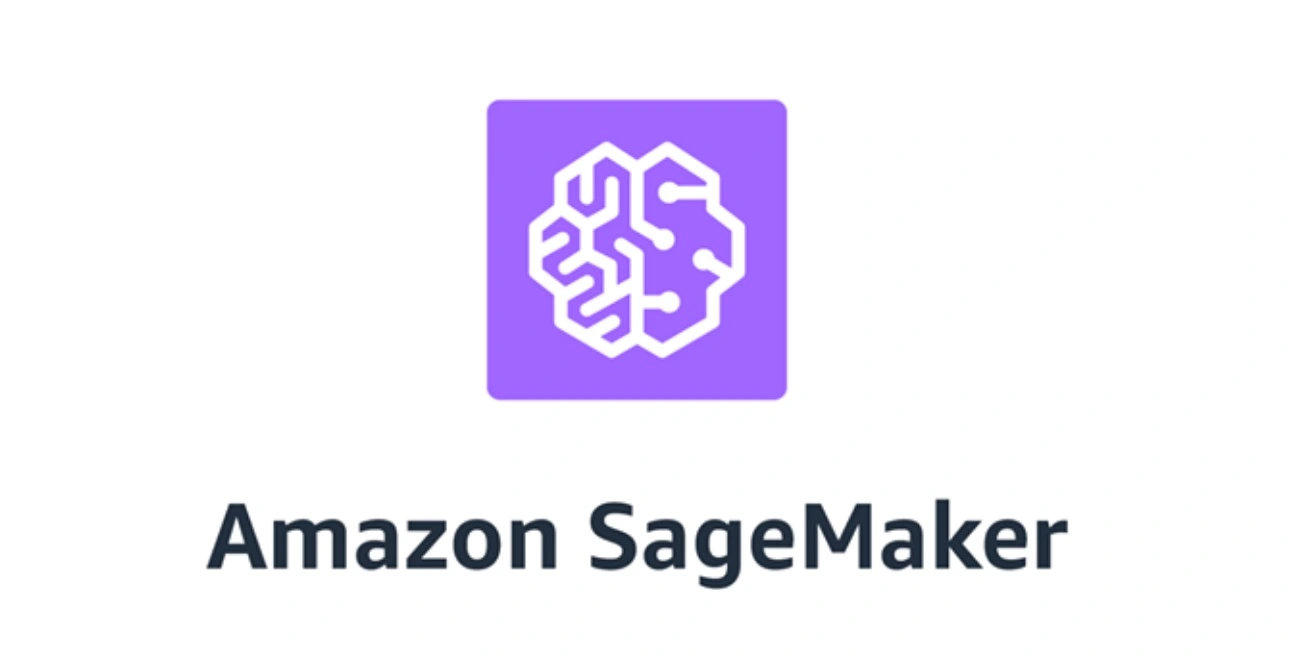

In [1]:
!pip install deflate

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for deflate: filename=deflate-0.3.0-cp310-cp310-linux_x86_64.whl size=35650 sha256=795a1c913c07320b9df2786f5898f3a6f9248a2e915e9a3aa923bfa5062b5e74
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e0/57/fb/688c5edb95442e3bdb3715d1c69d932d3fc80548e526827146
Successfully built deflate


In [2]:
!wget https://dl3.pushbulletusercontent.com/TvHPfXu81gCythGyuHcvDrvgoNgD26H5/code.zip
!unzip code.zip
!rm EC.py
!rm mnca.py

--2023-04-11 09:52:44--  https://dl3.pushbulletusercontent.com/TvHPfXu81gCythGyuHcvDrvgoNgD26H5/code.zip
Resolving dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)... 35.208.62.122
Connecting to dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)|35.208.62.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4933 (4.8K) [application/x-zip-compressed]
Saving to: ‘code.zip’

100%[======================================>] 4,933       --.-K/s   in 0s      

2023-04-11 09:52:44 (60.3 MB/s) - ‘code.zip’ saved [4933/4933]

Archive:  code.zip
  inflating: EC.py                   
  inflating: mnca.py                 
  inflating: neighborhoods/mask_c1.txt  
  inflating: neighborhoods/mask_c2.txt  
  inflating: neighborhoods/mask_c3.txt  


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import deflate
import os
import sys
np.set_printoptions(threshold=sys.maxsize)



def coarse_grain(input_grid,scale_factor):
    # Determine the size of the input grid
    n_rows, n_cols = input_grid.shape
    
    # Check that the input grid has an even number of rows and columns
    assert n_rows % 2 == 0 and n_cols % 2 == 0, "Input grid must have an even number of rows and columns"
    
    # Determine the size of the output grid
    out_n_rows, out_n_cols = n_rows // scale_factor, n_cols // scale_factor
    
    # Initialize the output grid
    output_grid = np.zeros((out_n_rows, out_n_cols))
    
    # Apply the coarse-graining mechanism to each block of pixels in the input grid
    for i in range(out_n_rows):
        for j in range(out_n_cols):
            block = input_grid[i*scale_factor:(i+1)*scale_factor, j*scale_factor:(j+1)*scale_factor]
            output_grid[i, j] = np.mean(block)
    
    return output_grid

def extract_neighborhood_from_file(file_name):
    with open(file_name, "r") as f:
        lines = f.readlines()
        neighborhood = []
        for i, line in enumerate(lines):
            line = line.strip()
            for j, value in enumerate(line.split(" ")):
                if value == "1":
                    neighborhood.append((i-1, j-1))
        return neighborhood



def init_board(width, height, init_state):
    if init_state == "single cell in center":
        board = np.zeros((height, width), dtype=np.int)
        board[height//2, width//2] = 1
    elif init_state == "random cells with some probability":
        p = 0.50 # probability of a cell being alive
        board = np.random.choice([0, 1], size=(height, width), p=[1-p, p])
    elif init_state == "random cells with 2 different states":
        p1 = 0.40 # probability of a cell being state 1
        board = np.random.choice([0, 1, 2], size=(height, width), p=[1-p1, p1/2, p1/2])
    else:
        raise ValueError("Invalid initial state")
    return board

def mnca(range_of_neighborhood_sums,scale_factor):   

    ###############----CONSTANTS----###############
    width = 100
    height = 100
    steps = 50
    init_state = "random cells with some probability"
    # Fixed Neighbohoods
    nh1 = extract_neighborhood_from_file('neighborhoods/mask_c1.txt')
    nh2 = extract_neighborhood_from_file('neighborhoods/mask_c2.txt')
    nh3 = extract_neighborhood_from_file('neighborhoods/mask_c3.txt')

    # neighborhoods = [nh1,nh2,nh3]
    neighborhoods = [nh1,nh2,nh3]
    board_arr = []
    board_arr_cg = []
    
    
    ###############----CONSTANTS----###############


    for eachstep in range(steps):
        board = init_board(width, height, init_state)
        new_board = np.zeros_like(board, dtype=int)
        height, width = board.shape
        for i in range(height):
            for j in range(width):
                next_state = board[i, j]
                for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                    cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                        for ni, nj in neighborhood]
                    
                    # # use this for sum
                    # neighborhood_sum = sum(cell_neighborhood)
                    
                    # use this for average
                    neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                    for lower, upper, new_next_state in range_of_neighborhood_sum:
                        if lower <= neighborhood_sum <= upper:
                            next_state = new_next_state
                new_board[i, j] = next_state
        board[:] = new_board[:]
        # print(board.shape)
        board_cg = coarse_grain(board,scale_factor) # Adding coarse graining here
        board_arr.append(board) # Storing board arrays
        board_arr_cg.append(board_cg) # Storing coarse grained board arrays
    # Calculate Deflate over that board array
    
    # Calculations for HD
    # Calculations for HD
    # Calculations for HD
    # Calculations for HD
    try:
        os.remove("board_arrays.txt")
        # print("Removed Successfully")
    except:
        pass
    with open("board_arrays.txt", "w") as output:
        output.write(str(board_arr))
    
    # filedata = open('board_arrays.txt', "rb").readlines()
    # print(filedata)
    filedata = open('board_arrays.txt', 'r', encoding='utf-8').readlines()
    filedata = ''.join(filedata).encode('utf-8')
    # print(filedata)
    compressed = deflate.gzip_compress(filedata, 8)
    deflate_hd = compressed.__sizeof__()


    # Calculations for CG
    # Calculations for CG
    # Calculations for CG
    # Calculations for CG
    try:
        os.remove("board_arrays_cg.txt")
        # print("Removed Successfully")
    except:
        pass
    with open("board_arrays_cg.txt", "w") as output:
        output.write(str(board_arr_cg))
    
    filedata_cg = open('board_arrays_cg.txt', 'r', encoding='utf-8').readlines()
    filedata_cg = ''.join(filedata_cg).encode('utf-8')
    compressed_cg = deflate.gzip_compress(filedata_cg, 8)
    deflate_cg = compressed_cg.__sizeof__()
    os.system("rm *.txt")   
    return deflate_hd,deflate_cg # fitness as HD , CG



# # Testing handlers

# nh_sum1 = [(0.210,0.220,1),(0.350, 0.500, 0), (0.750, 0.850, 0)]
# nh_sum2 = [(0.100,0.280,0),(0.430, 0.550, 1), (0.120, 0.150, 0)]
# range_of_neighborhood_sums = [nh_sum1,nh_sum2]
# print(mnca(range_of_neighborhood_sums))



Generation:  0
Best Individual: 
[[(0.968, 0.983, 1), (0.187, 0.99, 0), (0.154, 0.688, 1)], [(0.15, 0.865, 0), (0.719, 0.953, 1), (0.312, 0.625, 1)], [(0.86, 0.863, 1), (0.419, 0.486, 0), (0.969, 0.981, 1)]]
Best Fitness: 
167466
------------------------------------------------------------
Generation:  1
Best Individual: 
[[(0.968, 0.983, 1), (0.187, 0.99, 0), (0.154, 0.688, 1)], [(0.15, 0.865, 0), (0.719, 0.953, 1), (0.312, 0.625, 1)], [(0.86, 0.863, 1), (0.419, 0.486, 0), (0.969, 0.981, 1)]]
Best Fitness: 
78599
------------------------------------------------------------
Generation:  2
Best Individual: 
[[(0.968, 0.983, 1), (0.187, 0.99, 0), (0.154, 0.688, 1)], [(0.15, 0.865, 0), (0.719, 0.953, 1), (0.312, 0.625, 1)], [(0.86, 0.863, 1), (0.419, 0.486, 0), (0.969, 0.981, 1)]]
Best Fitness: 
60495
------------------------------------------------------------
Generation:  3
Best Individual: 
[[(0.968, 0.983, 1), (0.187, 0.99, 0), (0.154, 0.688, 1)], [(0.15, 0.865, 0), (0.719, 0.953, 1),

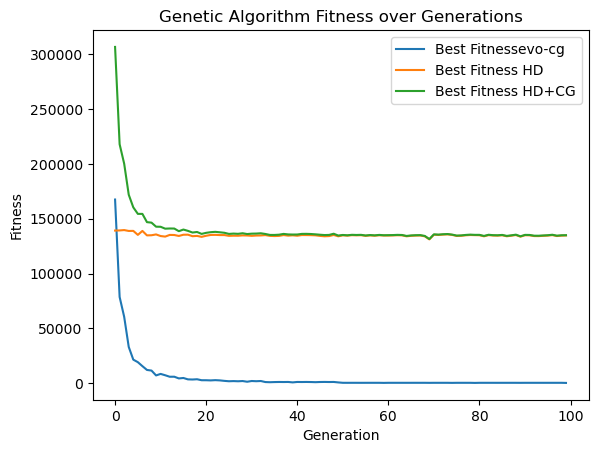

In [ ]:
from tempfile import tempdir
import numpy as np
import sys
import random
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)

# from mnca import mnca

OVERALL_PROBABILITY_ATLEAST = 1 # works as mutation rate
POPULATION_SIZE = 10 #3
GENERATION_SIZE = 100 #3
NUMBER_OF_NEIGHBORHOODS = 3 
NUMBER_OF_BOUNDS_IN_EACH_NEIGHBORHOOD = 3 

total_sum = 3*NUMBER_OF_NEIGHBORHOODS*NUMBER_OF_BOUNDS_IN_EACH_NEIGHBORHOOD



PROBABILITY_OF_INSERTING_A_NEW_RULE = OVERALL_PROBABILITY_ATLEAST/total_sum
PROBABILITY_OF_REMOVING_A_RULE = OVERALL_PROBABILITY_ATLEAST/total_sum
PROBABILITY_OF_CHANGING_A_RULE = OVERALL_PROBABILITY_ATLEAST/total_sum



def generate_random_rule():
    number_of_neighborhood = NUMBER_OF_NEIGHBORHOODS
    number_of_bounds_in_each_neighborhod_average_or_sum = NUMBER_OF_BOUNDS_IN_EACH_NEIGHBORHOOD
    rule = []
    for i in range(number_of_neighborhood):
        ranges = []
        for j in range(number_of_bounds_in_each_neighborhod_average_or_sum):
            lower = round(random.uniform(0, 1),3)
            upper = round(random.uniform(lower, 1),3)
            new_next_state = random.choice([0, 1]) 
            
            ranges.append((lower, upper, new_next_state))
        rule.append(ranges)
    return rule


def init_population():
    population_size = POPULATION_SIZE
    population = []
    for i in range(population_size):
        individual = generate_random_rule()
        population.append(individual)
    return population



def calculate_deflate(genotype,scale_factor):
    deflate_hd, deflate_cg = mnca(genotype,scale_factor)
    return deflate_hd, deflate_cg



def roulette_wheel_selection(population, fitness_values):

    sorted_population = [x for _,x in sorted(zip(fitness_values,population))]
    sorted_fitness_scores = [_ for _,x in sorted(zip(fitness_values,population))]
    fitness_values = sorted_fitness_scores
    population = sorted_population
    total_fitness = sum(fitness_values)
    probability_values = [fitness/total_fitness for fitness in fitness_values]
    cumulative_probability = np.cumsum(probability_values)
    selected_index = None
    random_value = random.uniform(0, 1)
    for i in range(len(population)):
        if random_value < cumulative_probability[i]:
            selected_index = i
            break

    return population[selected_index], fitness_values[selected_index]



def mutation(rule):
    try:
        number_of_neighborhoods = len(rule)
        for i in range(number_of_neighborhoods):
            number_of_bounds = len(rule[i])
            for j in range(number_of_bounds):
                prob_insert = PROBABILITY_OF_INSERTING_A_NEW_RULE
                prob_remove = PROBABILITY_OF_REMOVING_A_RULE
                prob_change = PROBABILITY_OF_CHANGING_A_RULE
                random_value = random.uniform(0, 1)
                if random_value < prob_insert:
                    new_bound = []
                    lower = round(random.uniform(0, 1),3)
                    upper = round(random.uniform(0, 1),3)
                    new_next_state = random.choice([0, 1])
                    if(lower>upper):
                        temp = lower
                        lower = upper
                        upper = temp
                    new_bound.append((lower, upper, new_next_state))
                    rule[i].extend(new_bound)
                elif prob_insert <= random_value < prob_insert + prob_remove:
                    if(len(rule[i])>NUMBER_OF_BOUNDS_IN_EACH_NEIGHBORHOOD): # Keeping at least NUMBER_OF_BOUNDS_IN_EACH_NEIGHBORHOOD bounds
                        rule[i].pop(j)
                        number_of_bounds -= 1
                        j -= 1
                    else:
                        mutation(rule[i])
                elif prob_insert + prob_remove <= random_value < prob_insert + prob_remove + prob_change:
                    delta = random.uniform(-0.100,0.100)
                    toss_a_coin = random.uniform(0,1)
                    if(toss_a_coin<0.33):
                        rule[i][j][0] = rule[i][j][0]+delta
                        if(rule[i][j][0] > 1):
                            rule[i][j][0] = 1
                        elif(rule[i][j][0] < 0):
                            rule[i][j][0] = 0
                    elif(0.33<toss_a_coin<0.66):
                        
                        rule[i][j][1] = rule[i][j][1]+delta
                        if(rule[i][j][1] > 1):
                            rule[i][j][1] = 1
                        elif(rule[i][j][1] < 0):
                            rule[i][j][1] = 0
                    else:
                        if(rule[i][j][2] ==0):
                            rule[i][j][2] = 1
                        else:
                            rule[i][j][2] = 0
                    if(rule[i][j][0] > rule[i][j][1]):
                        temp = rule[i][j][0]
                        rule[i][j][0] = rule[i][j][1]
                        rule[i][j][1] = temp
    except:
        pass
    return rule





population = init_population()
generations = GENERATION_SIZE

best_fitness_history = []
best_fitness_history_hd = []
best_fitness_history_hd_cg = []
average_fitness_history = []
worst_fitness_history = []

for generation in range(generations):
    print("Generation: ", generation)
    # CG based evolution
    # Calculate fitness of Individuals
    # Calculate fitness for each individual for Coarse graining
    fitness_values = [] # Fitness where using which evoltuion is running 
    fitness_values_hd = [] # Fitness where using which comparison will be made
    fitness_values_hd_cg = []
    
    # New piece of code 11 April
    for individual in population:
        # scale_factor = GENERATION_SIZE - generation
        scale_factor = generation+1
        deflate_hd, deflate_cg = calculate_deflate(individual,scale_factor)
        fitness_values.append(deflate_cg)
        fitness_values_hd.append(deflate_hd)
        fitness_values_hd_cg.append(deflate_hd+deflate_cg)
    # Preserving hisotry
    best_individual_index = np.argmax(fitness_values) # elite index
    best_individual_index_hd = np.argmax(fitness_values_hd) # elite index HD
    best_individual_index_hd_cg = np.argmax(fitness_values_hd_cg) # elite index HD+CG
    
    
    import copy
    
    best_individual = copy.deepcopy(population[best_individual_index]) # elite chromosome
    best_fitness = fitness_values[best_individual_index] # elite fitness
    best_fitness_hd = fitness_values_hd[best_individual_index] # using same index 
    best_fitness_hd_cg = fitness_values_hd_cg[best_individual_index] # using same index
    
    
    print("Best Individual: ") # print best chromo
    print(best_individual)
    print("Best Fitness: ") # print its fitness
    print(best_fitness)
    worst_individual_index = np.argmin(fitness_values) # worst history
    worst_fitness = fitness_values[worst_individual_index] # worst fitness

    avg_fitness = np.mean(fitness_values) # average fitness

    best_fitness_history.append(best_fitness) # preserving history
    best_fitness_history_hd.append(best_fitness_hd)
    best_fitness_history_hd_cg.append(best_fitness_hd_cg)
    
    average_fitness_history.append(avg_fitness) # preserving history
    worst_fitness_history.append(worst_fitness) # preserving history

    # print("old population: ")
    # print(population)
    # print("fitness values ")
    # print(fitness_values)
    # Preserving elite
    new_population = [best_individual]  # 1elites Elitism
    # print("new population ")
    # print(new_population)

    # Selection of the individuals
    while len(new_population) < POPULATION_SIZE:
        select1, _ = roulette_wheel_selection(population, fitness_values)
        # select2, _ = roulette_wheel_selection(population, fitness_values)
        # First deep copy and then mutation
        deep_copy = copy.deepcopy(select1)
        mutated1 = mutation(deep_copy)
        # mutated2 = mutation(select2)
        # deep_copy = copy.deepcopy(mutated1)
        # new_population.append(deep_copy)
        new_population.append(mutated1)

   
    # print("Brand new pop")
    # print(new_population)
    population = new_population
    # print("population after new population")
    # print(population)
    print("------------------------------------------------------------")
    # print("population in the end: ",population)
# Plot the graph
plt.plot(best_fitness_history, label="Best Fitnessevo-cg")
plt.plot(best_fitness_history_hd, label="Best Fitness HD") # based on same individual and its index
plt.plot(best_fitness_history_hd_cg, label="Best Fitness HD+CG") # based on same individual and its index
# plt.plot(average_fitness_history, label="Average Fitness")
# plt.plot(worst_fitness_history, label="Worst Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic Algorithm Fitness over Generations")
plt.legend()
plt.show()



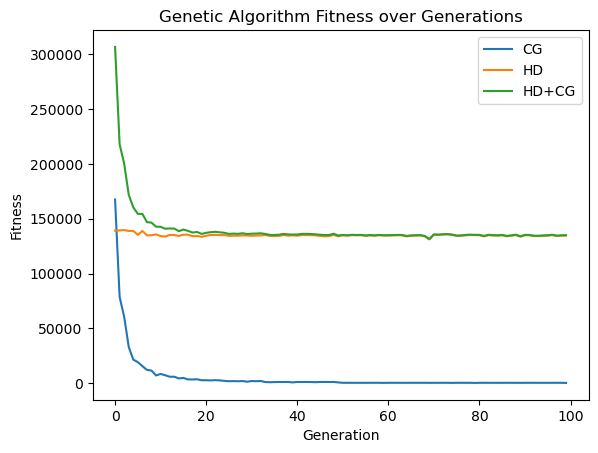

In [ ]:
plt.plot(best_fitness_history, label="CG")
plt.plot(best_fitness_history_hd, label="HD") # based on same individual and its index
plt.plot(best_fitness_history_hd_cg, label="HD+CG") # based on same individual and its index
# plt.plot(average_fitness_history, label="Average Fitness")
# plt.plot(worst_fitness_history, label="Worst Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic Algorithm Fitness over Generations")
plt.legend()
plt.show()



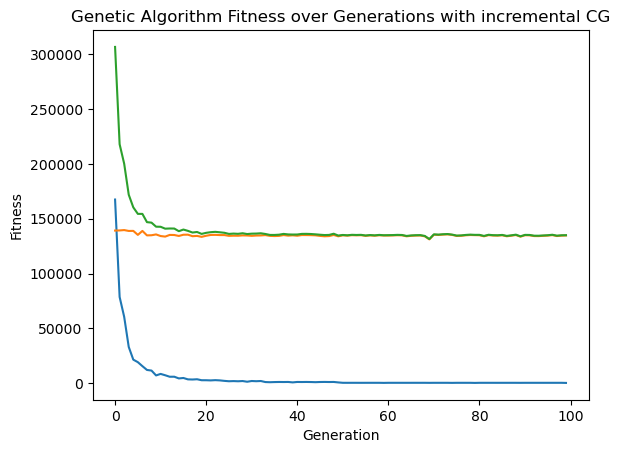

In [ ]:
plt.plot(best_fitness_history, label="CG")
plt.plot(best_fitness_history_hd, label="HD") # based on same individual and its index
plt.plot(best_fitness_history_hd_cg, label="HD+CG") # based on same individual and its index
# plt.plot(average_fitness_history, label="Average Fitness")
# plt.plot(worst_fitness_history, label="Worst Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic Algorithm Fitness over Generations with incremental CG")
# plt.legend()
plt.show()



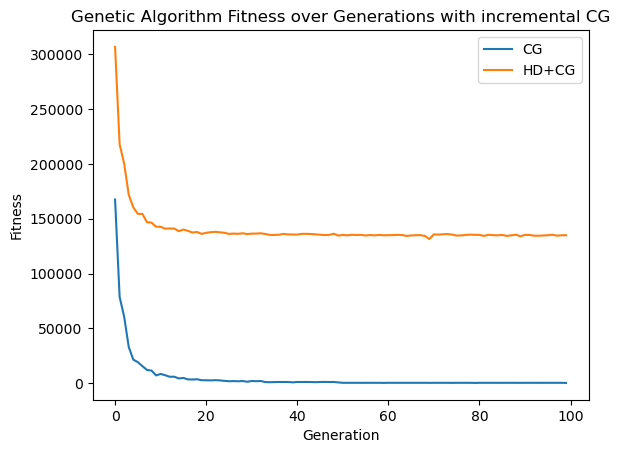

In [ ]:
plt.plot(best_fitness_history, label="CG")
# plt.plot(best_fitness_history_hd, label="HD") # based on same individual and its index
plt.plot(best_fitness_history_hd_cg, label="HD+CG") # based on same individual and its index
# plt.plot(average_fitness_history, label="Average Fitness")
# plt.plot(worst_fitness_history, label="Worst Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic Algorithm Fitness over Generations with incremental CG")
plt.legend()
plt.show()



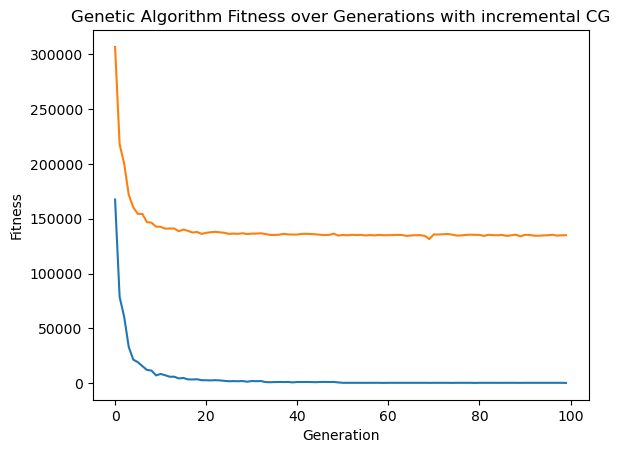

In [ ]:
plt.plot(best_fitness_history, label="CG")
# plt.plot(best_fitness_history_hd, label="HD") # based on same individual and its index
plt.plot(best_fitness_history_hd_cg, label="HD+CG") # based on same individual and its index
# plt.plot(average_fitness_history, label="Average Fitness")
# plt.plot(worst_fitness_history, label="Worst Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic Algorithm Fitness over Generations with incremental CG")
# plt.legend()
plt.show()

